In [1]:
# Jean setup:
import findspark
findspark.init()

pathBme = "C:\SofiaAirQuality\Bme"
pathSds = "C:\SofiaAirQuality\Sds"

In [2]:
# Luiz setup
# pathBme = "/home/luiz/SofiaAirQuality/OneMonthBme"
# pathSds = "/home/luiz/SofiaAirQuality/OneMonthSds"

In [3]:
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StringType
from pyspark.sql.functions import col, unix_timestamp, expr, avg, udf

from pyspark.ml.classification import NaiveBayes, RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GeneralizedLinearRegression, DecisionTreeRegressor

import matplotlib.pyplot as plt


In [4]:
# Configuração
spark = SparkSession \
    .builder \
    .master("local[8]") \
    .appName("tp_final_jean_luiz").getOrCreate()

df1Schema = StructType() \
    .add("_c0", "integer") \
    .add("sensor_id", "integer") \
    .add("location", "integer") \
    .add("lat", "double") \
    .add("long", "double") \
    .add("timestamp", "timestamp") \
    .add("pressure", "double") \
    .add("temperature", "double") \
    .add("humidity", "double") \

df2Schema = StructType() \
    .add("_c0", "integer") \
    .add("sensor_id", "integer") \
    .add("location", "integer") \
    .add("lat", "double") \
    .add("long", "double") \
    .add("timestamp", "timestamp") \
    .add("P1", "double") \
    .add("P2", "double") \

df1 = spark.read.schema(df1Schema).format("csv").load(pathBme, header=True)
df2 = spark.read.schema(df2Schema).format("csv").load(pathSds, header=True)

In [5]:
df1 = df1 \
    .withColumn("df1Location", df1.location) \
    .withColumn("df1Lat", df1.lat) \
    .withColumn("df1Long", df1.long) \
    .withColumn("df1Timestamp", df1.timestamp) \
    .withColumn("df1Id", df1.sensor_id).limit(20000)

df2 = df2 \
    .withColumn("df2Location", df2.location) \
    .withColumn("df2Lat", df2.lat) \
    .withColumn("df2Long", df2.long) \
    .withColumn("df2Timestamp", df2.timestamp) \
    .withColumn("df2Id", df2.sensor_id).limit(20000)

In [6]:
df1.count()

20000

In [7]:
df2.count()

20000

In [8]:
joined = df1.join(
  df2,
  expr("""
    df1Location = df2Location AND
    df1Timestamp <= df2Timestamp + interval 1 minutes AND
    df1Timestamp >= df2Timestamp - interval 1 minutes
    """)
)

In [9]:
joined.count()

12626

In [10]:
# TODO talvez tenha um jeito melhor de fazer isso

joinedWithoutDuplicates = joined.dropDuplicates(['df1Id', 'df1Timestamp'])

In [11]:
joinedWithoutDuplicates.count()

12626

In [12]:
columnsOfInterest = ['df1Id', 'df1Timestamp', 'df1Location', 'df2Id', 'df2Timestamp', 'df2Location', 'pressure', 'temperature', 'humidity', 'P1', 'P2']
joinedWithoutDuplicates.filter(joinedWithoutDuplicates.df1Id == 2266).select(*columnsOfInterest).show(100)

+-----+-------------------+-----------+-----+-------------------+-----------+--------+-----------+--------+-----+-----+
|df1Id|       df1Timestamp|df1Location|df2Id|       df2Timestamp|df2Location|pressure|temperature|humidity|   P1|   P2|
+-----+-------------------+-----------+-----+-------------------+-----------+--------+-----------+--------+-----+-----+
| 2266|2017-07-01 00:00:07|       1140| 2265|2017-07-01 00:00:06|       1140|95270.27|      23.46|   62.48|25.33| 6.57|
| 2266|2017-07-01 00:02:33|       1140| 2265|2017-07-01 00:02:33|       1140|95266.66|      23.37|    63.4| 15.7| 6.27|
| 2266|2017-07-01 00:05:00|       1140| 2265|2017-07-01 00:04:59|       1140|95258.14|      23.37|   63.22|18.17|  6.6|
| 2266|2017-07-01 00:07:26|       1140| 2265|2017-07-01 00:07:26|       1140|95267.81|      23.23|   63.07| 15.9| 6.83|
| 2266|2017-07-01 00:09:53|       1140| 2265|2017-07-01 00:09:52|       1140|95267.84|      23.25|   63.37|13.67| 5.97|
| 2266|2017-07-01 00:12:19|       1140| 

In [13]:
tmpp = joinedWithoutDuplicates \
    .withColumn("timestampDelta", joinedWithoutDuplicates.df2Timestamp.cast("long") - joinedWithoutDuplicates.df1Timestamp.cast("long")) \
    .withColumn("idDifference", joinedWithoutDuplicates.df2Id - joinedWithoutDuplicates.df1Id)

tmpp \
    .select("timestampDelta") \
    .agg(avg("timestampDelta")) \
    .show()

tmpp \
    .agg(avg("idDifference")) \
    .show()

+-------------------+
|avg(timestampDelta)|
+-------------------+
|-0.9884365594804372|
+-------------------+

+-----------------+
|avg(idDifference)|
+-----------------+
|             -1.0|
+-----------------+



In [14]:
columnsOfInterest = ['df1Id', 'df1Timestamp', 'df1Location', 'df2Id', 'df2Timestamp', 'df2Location', 'pressure', 'temperature', 'humidity', 'P1', 'P2']
joinedWithoutDuplicates.select(*columnsOfInterest).show(100)

+-----+-------------------+-----------+-----+-------------------+-----------+--------+-----------+--------+-----+-----+
|df1Id|       df1Timestamp|df1Location|df2Id|       df2Timestamp|df2Location|pressure|temperature|humidity|   P1|   P2|
+-----+-------------------+-----------+-----+-------------------+-----------+--------+-----------+--------+-----+-----+
| 2266|2017-07-01 00:00:07|       1140| 2265|2017-07-01 00:00:06|       1140|95270.27|      23.46|   62.48|25.33| 6.57|
| 2292|2017-07-01 00:00:08|       1154| 2291|2017-07-01 00:00:07|       1154|94355.83|      23.06|   59.46|15.07| 9.67|
| 3096|2017-07-01 00:00:10|       1558| 3095|2017-07-01 00:00:10|       1558|95155.81|      26.53|   44.38| 15.6| 6.43|
| 3428|2017-07-01 00:00:12|       1727| 3427|2017-07-01 00:00:12|       1727|94679.57|      28.34|   38.28|13.73| 6.43|
| 3472|2017-07-01 00:00:13|       1750| 3471|2017-07-01 00:00:12|       1750|94327.88|      26.31|   46.37| 20.9|10.67|
| 1952|2017-07-01 00:00:13|        976| 

C:\Spark\python\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
C:\Users\jeang\AppData\Local\Temp/ipykernel_16760/3667947647.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+attr)
C:\Users\jeang\AppData\Local\Temp/ipykernel_16760/3667947647.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+attr)


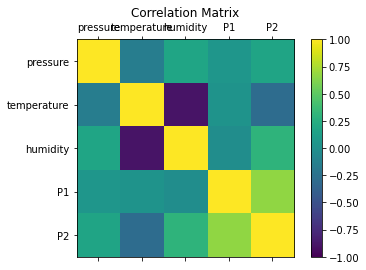

+--------------------+--------------------+--------------------+--------------------+--------------------+
|            pressure|         temperature|            humidity|                  P1|                  P2|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 1.0|  -0.148613713783019|  0.1764552301859791|0.051129495874957125| 0.16891626636409218|
|  -0.148613713783019|                 1.0| -0.8938982266520868|0.026008319509628886|-0.29194079850965093|
|  0.1764552301859791| -0.8938982266520868|                 1.0|-0.01707582739054...| 0.29964403899450776|
|0.051129495874957125|0.026008319509628886|-0.01707582739054...|                 1.0|  0.6642406182604631|
| 0.16891626636409218|-0.29194079850965093| 0.29964403899450776|  0.6642406182604631|                 1.0|
+--------------------+--------------------+--------------------+--------------------+--------------------+



In [15]:
# 1. Realizar uma análise da correlação entre os atributos presentes na base de dados 
# (pressão, temperatura, umidade, P1 (PM10) e P2 (PM2,5)).

# Filtrando apenas as colunas desejadas
columns = ['pressure','temperature','humidity', 'P1', 'P2']
df_filtered = joinedWithoutDuplicates.select(*columns)
df_filtered = df_filtered.filter(df_filtered.pressure.isNotNull())
df_filtered = df_filtered.filter(df_filtered.temperature.isNotNull())
df_filtered = df_filtered.filter(df_filtered.humidity.isNotNull())

# Criando coluna de vector
vector_column = "vector_column"
assembler = VectorAssembler(inputCols=df_filtered.columns, outputCol=vector_column)
df_vector = assembler.transform(df_filtered).select(vector_column)

# Obtendo matriz de correlação
matrix = Correlation.corr(df_vector, vector_column).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

# Plotando
def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(fig_no)
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()
plot_corr_matrix(corrmatrix, columns, 234)

spark.createDataFrame(corrmatrix,columns).show() # testando

In [16]:
# spark.createDataFrame(corrmatrix,columns).write.csv('correlation.csv', header=True)

In [17]:
# Questão 2

In [18]:
# Questao 3 - Inicio
df = joinedWithoutDuplicates \
    .withColumn("df1UnixTimestamp", unix_timestamp("df1Timestamp"))\
    .withColumn("df2UnixTimestamp", unix_timestamp("df2Timestamp"))

class PClass:
    def __init__(self, label, min, max=float('inf')):
        self.label = label
        self.min = min
        self.max = max

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   2.,
          2.,   2.,   2.,   0.,   3.,   6.,   2.,   1.,   4.,   5.,   5.,
          0.,   3.,   6.,   0.,   7.,   4.,   8.,  14.,   6.,  14.,   3.,
          8.,  14.,   5.,  13.,   3.,  11.,  12.,   5.,  11.,   4.,  12.,
          6.,   7.,  15.,   4.,   5.,   8.,   1.,  10.,   3.,   4.,  11.,
          5.,   8.,   5.,   8.,  17.,   6.,   7.,   7.,  15.,   7.,   7.,
         14.,  12.,  20.,  16.,  13.,   8.,  17.,  12.,  26.,  15.,   8.,
         12.,  29.,  40.,  19.,   9.,  24.,  29.,  50.,  26.,  29.,  40.,
         41.,  65.,  39.,  23.,  53.,  61.,  81.,  70.,  40.,  62.,  57.,
         84.,  62.,  36.,  78.,  64., 129.,  91.,  50.,  84.,  90., 115.,
        110.,  50.,  96., 111., 154., 107.,  77., 113.,  96., 103., 164.,
         73., 106., 126., 130., 178.,  70., 118., 112., 123., 162.,  80.,
        133., 119., 113., 160.,  78., 

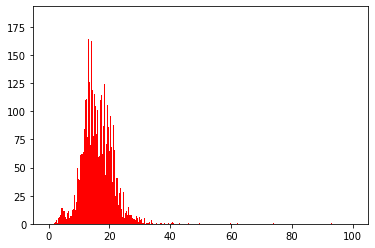

In [19]:
# Analisando histograma de P1 para decidir em quantos classes dividir
from pyspark_dist_explore import hist
fig, ax = plt.subplots()
hist(ax, df.select('P1'), bins = 1000, color=['red'], range=(0, 100))

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   2.,   0.,   2.,   4.,   4.,  12.,   5.,  14.,   9.,
         21.,   9.,   9.,  17.,   9.,  14.,   6.,   4.,   5.,   5.,  31.,
         11.,  26.,  46.,  63., 127.,  54.,  92., 194.,  73., 253.,  97.,
        190., 302., 127., 336., 115., 259., 382., 117., 339., 128., 271.,
        341., 118., 320., 126., 201., 302., 103., 284., 106., 195., 281.,
         92., 166., 204., 196., 270.,  92., 179., 193., 186., 341.,  85.,
        176., 189., 190., 278., 170.,  93., 166., 162., 229., 166.,  77.,
        137., 114., 177., 128.,  59., 112., 104., 132.,  98.,  44.,  91.,
         81., 124.,  78.,  31.,  80.,  64.,  89.,  54.,  20.,  44.,  46.,
         72.,  42.,  29.,  42.,  37.,  51.,  36.,  11.,  36.,  15.,  34.,
         22.,  12.,  16.,  19.,  23.,  19.,   3.,   9.,   6.,  11.,   8.,
          2.,   7.,   0.,   2.,   6.,   0.,   5.,   2.,   3.,   2.,   0.,
          0.,   5.,   1.,   3.,   2., 

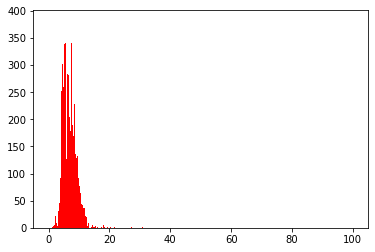

In [20]:
# Analisando histograma de P2 para decidir em quantos classes dividir
from pyspark_dist_explore import hist
fig, ax = plt.subplots()
hist(ax, df.select('P2'), bins = 1000, color=['red'], range=(0, 100))

In [21]:
# Definindo classes de P1
# P1Classes = [
#     PClass("low <= 5", -1, 5),
#     PClass("low <= 10", 5, 10),
#     PClass("low <= 15", 10, 15),
#     PClass("low <= 20", 15, 20),
#     PClass("low <= 25", 20, 25),
#     PClass("low <= 30", 25, 30),
#     PClass("low <= 35", 30, 35),
#     PClass("low <= 50", 35, 50),
#     PClass("medium ", 50, 75),
#     PClass("high", 75, 100),
#     PClass("very high", 100),
# ]

P1Classes = [
    PClass("low <= 10", 0, 10),
    PClass("low <= 20", 10, 20),
    PClass("low <= 30", 20, 30),
    PClass("low <= 40", 20, 40),
    PClass("low <= 50", 40, 50),
    PClass("medium ", 50, 75),
    PClass("high", 75, 100),
    PClass("very high", 100),
]
def getP1Class(value):
    for P1Class in P1Classes:
        if value > P1Class.min and value <= P1Class.max:
            return P1Class.label

# Preenchendo as classes no dataframe
getBandUdf = udf(getP1Class, StringType())
df = df.withColumn('P1Class', getBandUdf(df['P1']))

# Indexando
indexer = StringIndexer(inputCol="P1Class", outputCol="P1Indexed")
indexed = indexer.fit(df).transform(df)

df = indexed

# Testando
indexed.select('P1', 'P1Class', 'P1Indexed').show(20)

+-----+---------+---------+
|   P1|  P1Class|P1Indexed|
+-----+---------+---------+
|25.33|low <= 30|      1.0|
|15.07|low <= 20|      0.0|
| 15.6|low <= 20|      0.0|
|13.73|low <= 20|      0.0|
| 20.9|low <= 30|      1.0|
| 4.23|low <= 10|      2.0|
|10.83|low <= 20|      0.0|
|12.77|low <= 20|      0.0|
| 5.27|low <= 10|      2.0|
|19.03|low <= 20|      0.0|
|16.47|low <= 20|      0.0|
|  6.6|low <= 10|      2.0|
| 22.5|low <= 30|      1.0|
|14.93|low <= 20|      0.0|
|14.37|low <= 20|      0.0|
|16.43|low <= 20|      0.0|
|13.83|low <= 20|      0.0|
| 16.7|low <= 20|      0.0|
| 13.1|low <= 20|      0.0|
|10.87|low <= 20|      0.0|
+-----+---------+---------+
only showing top 20 rows



In [22]:
# Definindo classes de P2
# P2Classes = [
#     PClass("low <= 5", -1, 5),
#     PClass("low <= 10", 5, 10),
#     PClass("low <= 15", 10, 15),
#     PClass("low <= 20", 15, 20),
#     PClass("low <= 25", 20, 25),
#     PClass("low <= 30", 25, 30),
#     PClass("low <= 35", 30, 35),
#     PClass("medium ", 35, 54),
#     PClass("high", 54, 70),
#     PClass("very high", 70),
# ]

P2Classes = [
    PClass("low <= 10", -1, 10),
    PClass("low <= 20", 10, 20),
    PClass("low <= 30", 20, 30),
    PClass("medium ", 30, 54),
    PClass("high", 54, 70),
    PClass("very high", 70),
]

def getP2Class(value):
    for P2Class in P2Classes:
        if value > P2Class.min and value <= P2Class.max:
            return P2Class.label

# Preenchendo as classes no dataframe
getBandUdf = udf(getP2Class, StringType())
df = df.withColumn('P2Class', getBandUdf(df['P2']))

# Indexando
indexer = StringIndexer(inputCol="P2Class", outputCol="P2Indexed")
indexed = indexer.fit(df).transform(df)

df = indexed

# Testando
df.select('P2', 'P2Class', 'P2Indexed').show(20)

+-----+---------+---------+
|   P2|  P2Class|P2Indexed|
+-----+---------+---------+
| 6.57|low <= 10|      0.0|
| 9.67|low <= 10|      0.0|
| 6.43|low <= 10|      0.0|
| 6.43|low <= 10|      0.0|
|10.67|low <= 20|      1.0|
| 2.57|low <= 10|      0.0|
| 5.47|low <= 10|      0.0|
|  7.7|low <= 10|      0.0|
| 4.77|low <= 10|      0.0|
| 7.93|low <= 10|      0.0|
| 8.17|low <= 10|      0.0|
|  4.7|low <= 10|      0.0|
|  6.2|low <= 10|      0.0|
|  9.5|low <= 10|      0.0|
| 6.47|low <= 10|      0.0|
| 5.43|low <= 10|      0.0|
| 9.03|low <= 10|      0.0|
|  6.4|low <= 10|      0.0|
|  7.6|low <= 10|      0.0|
|  6.6|low <= 10|      0.0|
+-----+---------+---------+
only showing top 20 rows



In [23]:
def doMachineLearning(inputCols, originalCol, labelCol, featuresCol): # (belo nome de metodo)
  # Criando a coluna de features
  assembler = VectorAssembler(inputCols=inputCols, outputCol=featuresCol)
  transformedDf = assembler.transform(df)

  # Definindo amostra de treino e de teste
  [train, test] = transformedDf.randomSplit([0.8, 0.2])
  
  # Criando classificador
  classifier = RandomForestClassifier(labelCol=labelCol, featuresCol=featuresCol)
  # classifier = MultilayerPerceptronClassifier(labelCol=labelCol, layers=[len(featuresCol)+1, 8, 8])
  # # classifier = LinearRegression(labelCol=target, featuresCol="features")
  # # classifier = NaiveBayes(labelCol=target, featuresCol="features")
  # # classifier = DecisionTreeRegressor(labelCol=target, featuresCol="features")
  # # classifier =  RandomForestRegressor(labelCol=target, featuresCol="features")
  # # classifier = GeneralizedLinearRegression(labelCol=target,featuresCol="features")
  
  # Criando pipeline
  pipeline = Pipeline(stages=[classifier])

  # Treinando o modelo
  model = pipeline.fit(train)

  # Fazendo as predições
  predictions = model.transform(test)

  # Calculando a precisão
  evaluation = MulticlassClassificationEvaluator(labelCol=labelCol, predictionCol="prediction", metricName="accuracy")
  accuracy = evaluation.evaluate(predictions)

  # Mostrando resultados
  print("accuracy = %s" % accuracy)
  # predictions.select(originalCol, labelCol, "prediction").show()

In [27]:
# Machine learning pra P1
inputColsP1 = ['pressure', 'temperature', 'humidity', 'df1UnixTimestamp', 'df1Lat', 'df1Long']
doMachineLearning(inputColsP1, "P1", "P1Indexed", "features")

accuracy = 0.7675404780262144


In [30]:
# Machine learning pra P2
inputColsP2 = ['pressure', 'temperature', 'humidity', 'df1UnixTimestamp', 'df1Lat', 'df1Long']
doMachineLearning(inputColsP2, "P2", "P2Indexed", "features")

accuracy = 0.9240654205607477
